<a href="https://colab.research.google.com/github/kuds/rl-car-racing/blob/main/%5BCar%20Racing%5D%20Deep%20Q-Network%20(DQN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Q-Network (DQN)

In [1]:
!pip install swig

In [2]:
!pip install gymnasium gymnasium[box2d] stable_baselines3

In [3]:
import gymnasium
from gymnasium.wrappers import RecordVideo
from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecFrameStack, VecVideoRecorder
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import VecTransposeImage

import os
import numpy
import platform
import scipy
import stable_baselines3
import IPython
import matplotlib
import matplotlib.pyplot
import torch
import time
from importlib.metadata import version

In [4]:
print(f"Python Version: {platform.python_version()}")
print(f"Torch Version: {version('torch')}")
print(f"Is Cuda Available: {torch.cuda.is_available()}")
print(f"Cuda Version: {torch.version.cuda}")
print(f"Gymnasium Version: {version('gymnasium')}")
print(f"Numpy Version: {version('numpy')}")
print(f"Stable Baselines3 Version: {version('stable_baselines3')}")
print(f"Scipy Version: {version('scipy')}")
print(f"IPython Version: {version('ipython')}")

Python Version: 3.10.12
Torch Version: 2.4.0+cu121
Is Cuda Available: True
Cuda Version: 12.1
Gymnasium Version: 0.29.1
Numpy Version: 1.26.4
Stable Baselines3 Version: 2.3.2
Scipy Version: 1.13.1
IPython Version: 7.34.0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
backend = torch.backends.quantized.engine
print(f"Currently using backend: {backend}")

Currently using backend: x86


In [7]:
env = gymnasium.make('CarRacing-v2', continuous=False)
print("Observation Space Size: ", env.observation_space)
print("Action Space Size: ", env.action_space)
env.close()

Observation Space Size:  Box(0, 255, (96, 96, 3), uint8)
Action Space Size:  Discrete(5)


In [8]:
env_str = "CarRacing-v2"
log_dir = "./logs/{}".format(env_str)
env_kwargs_dict={"continuous":False}

In [ ]:
# Create Training CarRacing environment
env = make_vec_env(env_str, n_envs=1, env_kwargs=env_kwargs_dict)
env = VecFrameStack(env, n_stack=4)
env = VecTransposeImage(env)

# Create Evaluation CarRacing environment
env_val = make_vec_env(env_str, n_envs=1, env_kwargs=env_kwargs_dict)
env_val = VecFrameStack(env_val, n_stack=4)
env_val = VecTransposeImage(env_val)

# Create Evaluation Callback
# eval_freq - can cause learning instability if set to low
eval_callback = EvalCallback(env_val,
                             best_model_save_path=log_dir,
                             log_path=log_dir,
                             eval_freq=20000,
                             render=False,
                             n_eval_episodes=20)

# Initialize DQN
# buffer_size - encourages exploration of other actions
model = DQN('CnnPolicy', env, verbose=0, buffer_size=200000)

# Train the model
model.learn(total_timesteps=1000000, progress_bar=True, callback=eval_callback)

# Save the model
model.save(os.path.join(log_dir, "dqn_car_racing"))

mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=20)
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

env.close()
env_val.close()

In [ ]:
# Create Evaluation CarRacing environment
env = make_vec_env(env_str, n_envs=1, seed=0, env_kwargs=env_kwargs_dict)
env = VecFrameStack(env, n_stack=4)
env = VecTransposeImage(env)

# Load the best model
best_model_path = os.path.join(log_dir, "best_model.zip")
best_model = DQN.load(best_model_path, env=env)

mean_reward, std_reward = evaluate_policy(best_model, env, n_eval_episodes=20)
print(f"Best Model - Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

# Record video of the best model playing CarRacing
env = VecVideoRecorder(env, "./videos/",
                       video_length=10000,
                       record_video_trigger=lambda x: x == 0,
                       name_prefix="best_model_car_racing_dqn")

obs = env.reset()
for _ in range(10000):
    action, _states = best_model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    env.render()
    if dones:
        break

env.close()

Best Model - Mean reward: 811.63 +/- 95.40
Moviepy - Building video /content/videos/best_model_car_racing_dqn-step-0-to-step-10000.mp4.
Moviepy - Writing video /content/videos/best_model_car_racing_dqn-step-0-to-step-10000.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/best_model_car_racing_dqn-step-0-to-step-10000.mp4


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


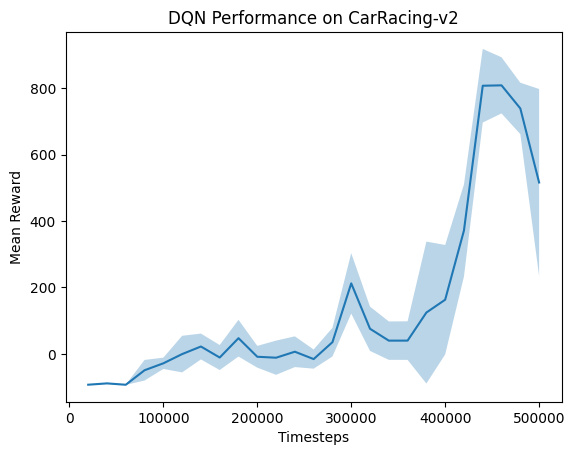

In [ ]:
# Load the evaluations.npz file
data = numpy.load(os.path.join(log_dir, "evaluations.npz"))

# Extract the relevant data
timesteps = data['timesteps']
results = data['results']

# Calculate the mean and standard deviation of the results
mean_results = numpy.mean(results, axis=1)
std_results = numpy.std(results, axis=1)

# Plot the results
matplotlib.pyplot.figure()
matplotlib.pyplot.plot(timesteps, mean_results)
matplotlib.pyplot.fill_between(timesteps,
                               mean_results - std_results,
                               mean_results + std_results,
                               alpha=0.3)

matplotlib.pyplot.xlabel("Timesteps")
matplotlib.pyplot.ylabel("Mean Reward")
matplotlib.pyplot.title(f"DQN Performance on {env_str}")
matplotlib.pyplot.show()